# Rutas directorio de los archivos

In [17]:
# Ruta a los modelos de adaboost
import os


ruta_modelos_adaboost = './modelos/adaboost/'
ruta_modelos_rf = './modelos/randomforest/'
ruta_modelos_stacking = './modelos/stacking/'
ruta_lectura_dataset = './Datasets/'

os.makedirs(ruta_modelos_adaboost, exist_ok=True)
os.makedirs(ruta_modelos_rf, exist_ok=True)
os.makedirs(ruta_modelos_stacking, exist_ok=True)


# Importación de librerias

In [3]:
# Librerías necesarias
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats

# Scikit-learn: preprocesamiento, modelos, métricas, y utilidades
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import (
    AdaBoostClassifier, 
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    StackingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report, 
    ConfusionMatrixDisplay
)

# Visualización de métricas
import seaborn as sns
import matplotlib.pyplot as plt

# Guardar y cargar modelos
import joblib


In [4]:
# Versión de python
print(f"Versión de Python: {sys.version.split()[0]}")

# Versión de pandas
print(f"Versión de pandas: {pd.__version__}")

# Versión de numpy
print(f"Versión de numpy: {np.__version__}")

# Versión de seaborn
print(f"Versión de seaborn: {sns.__version__}")

# Versión de matplotlib
print(f"Versión de matplotlib: {plt.matplotlib.__version__}")

# Versión de scikit-learn
print(f"Versión de scikit-learn: {joblib.__version__}")

# Versión de joblib
print(f"Versión de joblib: {joblib.__version__}")

# Versión de scipy
print(f"Versión de scipy: {scipy.__version__}")


Versión de Python: 3.10.15
Versión de pandas: 2.2.2
Versión de numpy: 1.26.4
Versión de seaborn: 0.13.2
Versión de matplotlib: 3.9.2
Versión de scikit-learn: 1.4.2
Versión de joblib: 1.4.2
Versión de scipy: 1.13.1


# Establecimiento de las semillas

In [5]:
semilla = 123
np.random.seed(semilla)

# Descripción del dataset



El dataset tarjeta crédito recoge variables de clientes para determinar si se les concede o no
 una tarjeta de crédito a usuarios de un banco. El datasets cuenta con 15 atributos con nombres
 ficticios para preservar la identidad de las personas. Estos atributos son:
- D1 nominal
- D2 numérica
- D3 numérica
- D4 nominal
- D5 nominal
- D6 nominal
- D7 nominal
- D8 numérica
- D9 nominal
- D10 nominal
- D11 numérica
- D12 nominal
- D13 nominal
- D14 numérica
- D15 numérica

El atributo objetivo es concedido que indica si se ha concedido o no el crédito.

# Preprocesamiento

Leemos el dataset y le echamos un pequeño vistazo a las primeras 5 instancias

In [18]:
tarjeta_credito = pd.read_csv(ruta_lectura_dataset + 'TarjetaCredito.csv')
tarjeta_credito.head()

D1      D2      D3 D4 D5 D6 D7     D8 D9 D10  D11 D12 D13  D14  D15  \
0  b  3083.0     0.0  u  g  w  v  125.0  t   t    1   f   g  202    0   
1  a  5867.0   446.0  u  g  q  h  304.0  t   t    6   f   g   43  560   
2  a   245.0     5.0  u  g  q  h   15.0  t   f    0   f   g  280  824   
3  b  2783.0   154.0  u  g  w  v  375.0  t   t    5   t   g  100    3   
4  b  2017.0  5625.0  u  g  w  v  171.0  t   f    0   f   s  120    0   

  concedido  
0        SI  
1        SI  
2        SI  
3        SI  
4        SI

Mostramos los datos de cada columna

In [7]:
tarjeta_credito.dtypes

D1            object
D2            object
D3           float64
D4            object
D5            object
D6            object
D7            object
D8           float64
D9            object
D10           object
D11            int64
D12           object
D13           object
D14           object
D15            int64
concedido     object
dtype: object

Si nos fijamos en el archivo `TarjetaCredito.names`, deberían haber **10 columnas categóricas** y **6 columnas numéricas**. Sin embargo, al cargar el dataset, observamos que hay solo **4 columnas numéricas**. Por lo tanto, decidimos transformar las columnas `D2` y `D14` a formato numérico.


In [8]:
tarjeta_credito['D2'] = pd.to_numeric(tarjeta_credito['D2'], errors='coerce')
tarjeta_credito['D14'] = pd.to_numeric(tarjeta_credito['D14'], errors='coerce')

Vamos a ver algunas métricas estadísticas sobre las variables numéricas que tenemos

In [9]:
# Para mostrar todas las columnas
pd.set_option('display.max_columns', None)

tarjeta_credito.describe()

D2            D3            D8        D11          D14  \
count   678.000000    690.000000    690.000000  690.00000   677.000000   
mean   2689.148968   1187.315942    453.366667    2.40000   184.014771   
std    1567.060784   3069.110042   1387.900324    4.86294   173.806768   
min      16.000000      0.000000      0.000000    0.00000     0.000000   
25%    1921.000000     15.000000      5.000000    0.00000    75.000000   
50%    2600.000000    125.000000     35.000000    0.00000   160.000000   
75%    3570.750000    665.000000    219.750000    3.00000   276.000000   
max    8025.000000  26335.000000  14415.000000   67.00000  2000.000000   

                 D15  
count     690.000000  
mean     1017.385507  
std      5210.102598  
min         0.000000  
25%         0.000000  
50%         5.000000  
75%       395.500000  
max    100000.000000

1. **Rango amplio en los valores de las columnas:**
   - Las columnas `D3`, `D8`, y `D15` muestran un rango considerablemente amplio de valores. Por ejemplo, `D3` tiene un valor mínimo de 0 y un valor máximo de 26.335, lo que indica una alta variabilidad en los datos.
   - Similarmente, `D8` tiene un rango entre 0 y 14.415, lo que sugiere una dispersión considerable en esta columna también.
   - `D15` tiene un valor máximo de 100.000, lo que también indica la presencia de valores atípicos extremos en este conjunto de datos.

2. **Valores atípicos en las columnas:**
   - **`D3`** tiene una desviación estándar de 3069'11, lo que sugiere una alta dispersión y posiblemente la presencia de valores atípicos que se alejan significativamente de la media (1187'31).
   - **`D8`** tiene una desviación estándar de 1387'90, lo que también indica que algunos valores podrían ser bastante alejados de la media (453'37).
   - **`D15`** tiene una desviación estándar muy alta (5210'10), lo que refuerza la hipótesis de que los valores atípicos son un factor importante, especialmente dado su máximo valor de 100.000.

3. **Distribución de las columnas:**
   - **`D11`** tiene una media de 2'4 con un valor máximo de 67, lo que sugiere que la mayoría de los datos están concentrados en valores cercanos a 0 (ya que la mediana es 0), con pocos casos alcanzando valores más altos.
   - En cambio, **`D14`** tiene una media de 184'01, y su mediana es de 160, lo que indica que los valores están más distribuidos alrededor de un rango moderado, sin valores extremos tan pronunciados como en otras columnas.

4. **Columnas con valores nulos:**
   - La columna **`D2`** tiene 677 valores no nulos, mientras que las otras columnas tienen 690 valores no nulos, lo que sugiere que hay pocos datos faltantes en la mayoría de las columnas es la columna **`D2`** la que más datos **NA**.

5. **Valores concentrados en el rango bajo:**
   - Las columnas **`D11`** y **`D8`** muestran que los primeros cuartiles (25%) tienen valores muy bajos (por ejemplo, en `D11` el 25% de los datos son 0), lo que indica que una parte significativa de los datos están muy cerca de cero.



En el **boxplot** a continuación, podemos observar lo mencionado previamente. Para mejorar la visibilidad del gráfico, hemos aplicado una **escala logarítmica**, lo que permite una mejor representación de las diferencias en los datos, especialmente en aquellos con rangos amplios o valores atípicos.


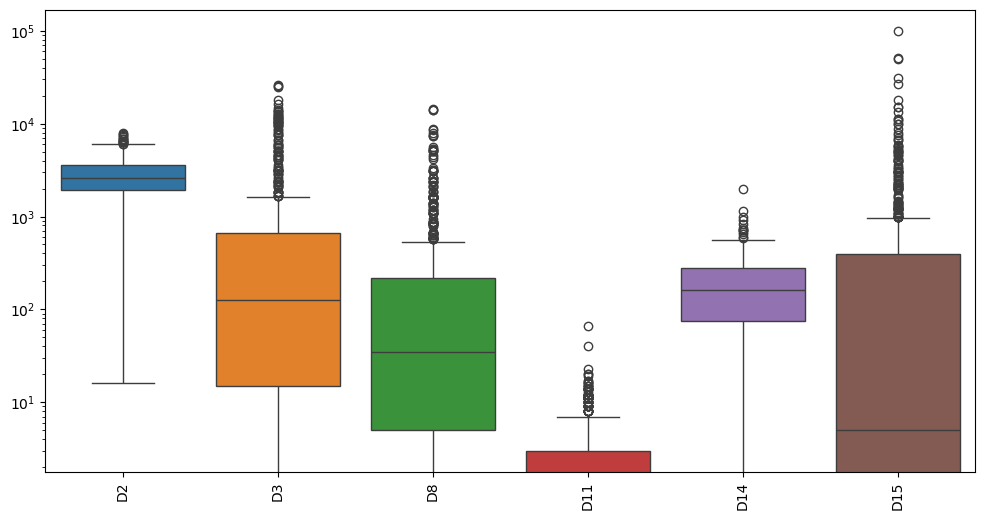

In [10]:

# Configura el tamaño de la figura
plt.figure(figsize=(12, 6))

# Crea el boxplot
sns.boxplot(data=tarjeta_credito, showfliers=True)  # Cambia `showfliers=True` si quieres ver los outliers

# Ajusta las etiquetas del eje X y rota si es necesario
plt.xticks(rotation=90)

# Opcional: aplicar escala logarítmica en el eje Y si los valores varían mucho
plt.yscale('log')

# Muestra el gráfico
plt.show()

Ahora vamos a examinar más a fondo los valores nulos en nuestro dataset. En este caso, los valores nulos están representados por el carácter `?`. Por lo tanto, reemplazamos este símbolo por el valor `NaN` y luego contamos la cantidad de valores faltantes en cada columna.

In [11]:
tarjeta_credito.replace('?', np.nan, inplace=True)
tarjeta_credito.isnull().sum()

D1           12
D2           12
D3            0
D4            6
D5            6
D6            9
D7            9
D8            0
D9            0
D10           0
D11           0
D12           0
D13           0
D14          13
D15           0
concedido     0
dtype: int64

Contamos con variables nulas tanto en columnas numéricas como categóricas. Por ello, en el análisis posterior exploraremos la aplicación de modelos de ensemble utilizando tres conjuntos de datos diferentes:

1. En el **primer conjunto**, eliminaremos todas las instancias que contengan al menos un valor nulo.
2. En el **segundo conjunto**, imputaremos los valores nulos numéricos con la **media** de la columna correspondiente y los valores nulos categóricos con la **moda** de la columna.
3. Finalmente, en el **tercer conjunto**, utilizaremos el algoritmo **KNN (K-Vecinos más cercanos)** para imputar los valores nulos, rellenándolos con los datos más cercanos.


A continuación, examinaremos si las variables numéricas siguen una distribución normal utilizando los **QQ-plots**.

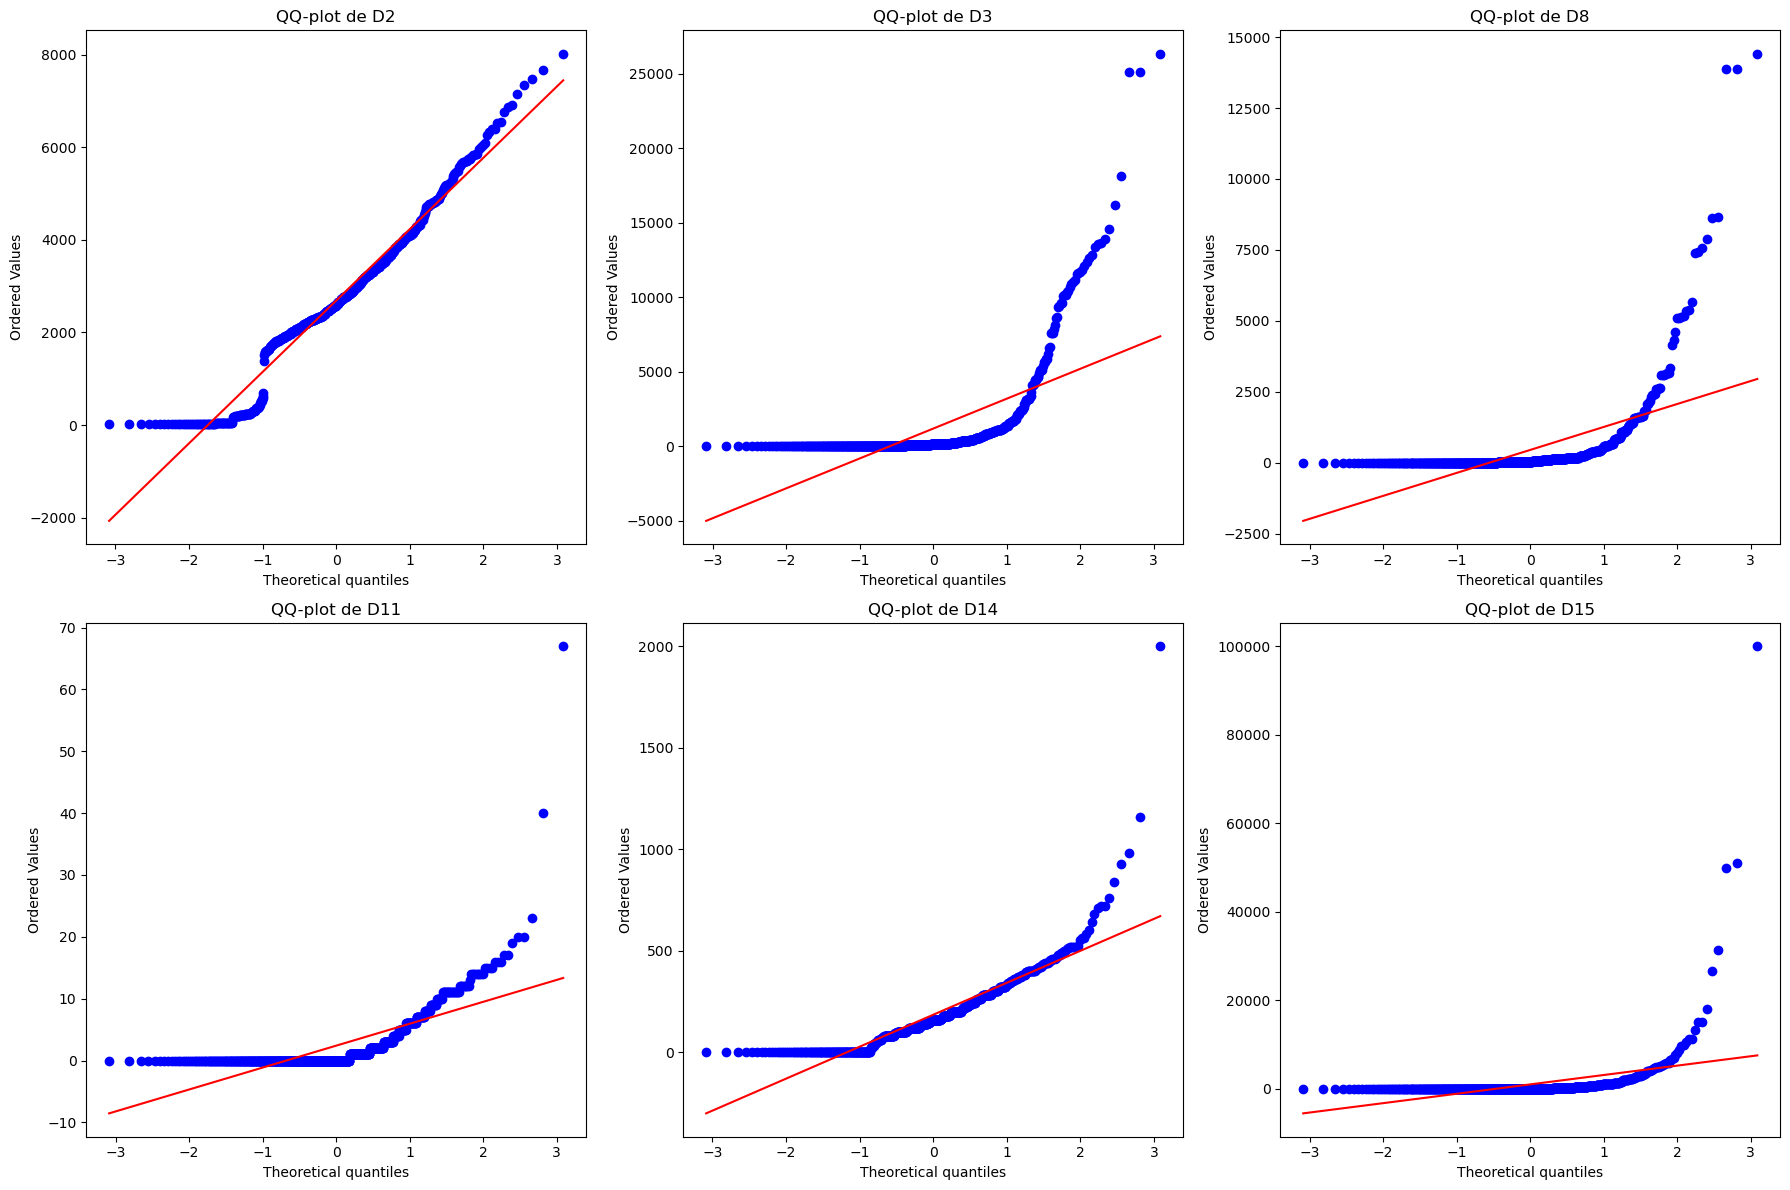

In [12]:


numerical_vars = tarjeta_credito.select_dtypes(include=["int64", "float64"]).columns

# Definir el número de filas y columnas para el gráfico
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Aplanar el arreglo de subgráficos para facilitar el acceso
axes = axes.flatten()

# Crear un QQ-plot para cada variable numérica
for i, var in enumerate(numerical_vars):
    stats.probplot(tarjeta_credito[var].dropna(), dist="norm", plot=axes[i])
    axes[i].set_title(f'QQ-plot de {var}')

# Ajustar el layout para que las gráficas no se superpongan
plt.tight_layout()
plt.show()

Podemos observar que solo la variable `D2` parece seguir una distribución normal.

A continuación, vamos a visualizar la relación entre las variables categóricas y la variable objetivo, para identificar si alguna de ellas parece ser más significativa que las demás de manera preliminar.


-- D1 --

Categoría: a, NO=112, SI=98
Categoría: b, NO=262, SI=206

-- D4 --

Categoría: l, NO=0, SI=2
Categoría: u, NO=263, SI=256
Categoría: y, NO=118, SI=45


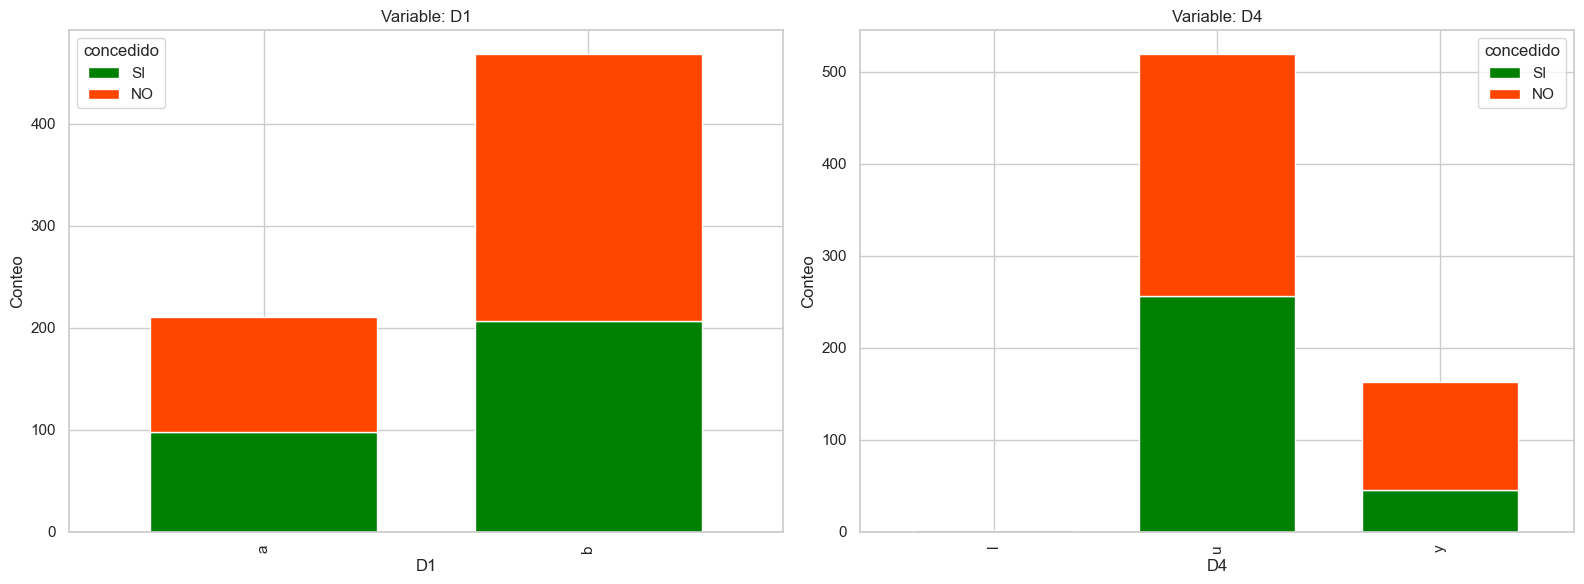


-- D5 --

Categoría: g, NO=263, SI=256
Categoría: gg, NO=0, SI=2
Categoría: p, NO=118, SI=45

-- D6 --

Categoría: aa, NO=35, SI=19
Categoría: c, NO=75, SI=62
Categoría: cc, NO=12, SI=29
Categoría: d, NO=23, SI=7
Categoría: e, NO=11, SI=14
Categoría: ff, NO=46, SI=7
Categoría: i, NO=45, SI=14
Categoría: j, NO=7, SI=3
Categoría: k, NO=37, SI=14
Categoría: m, NO=22, SI=16
Categoría: q, NO=27, SI=51
Categoría: r, NO=1, SI=2
Categoría: w, NO=31, SI=33
Categoría: x, NO=6, SI=32


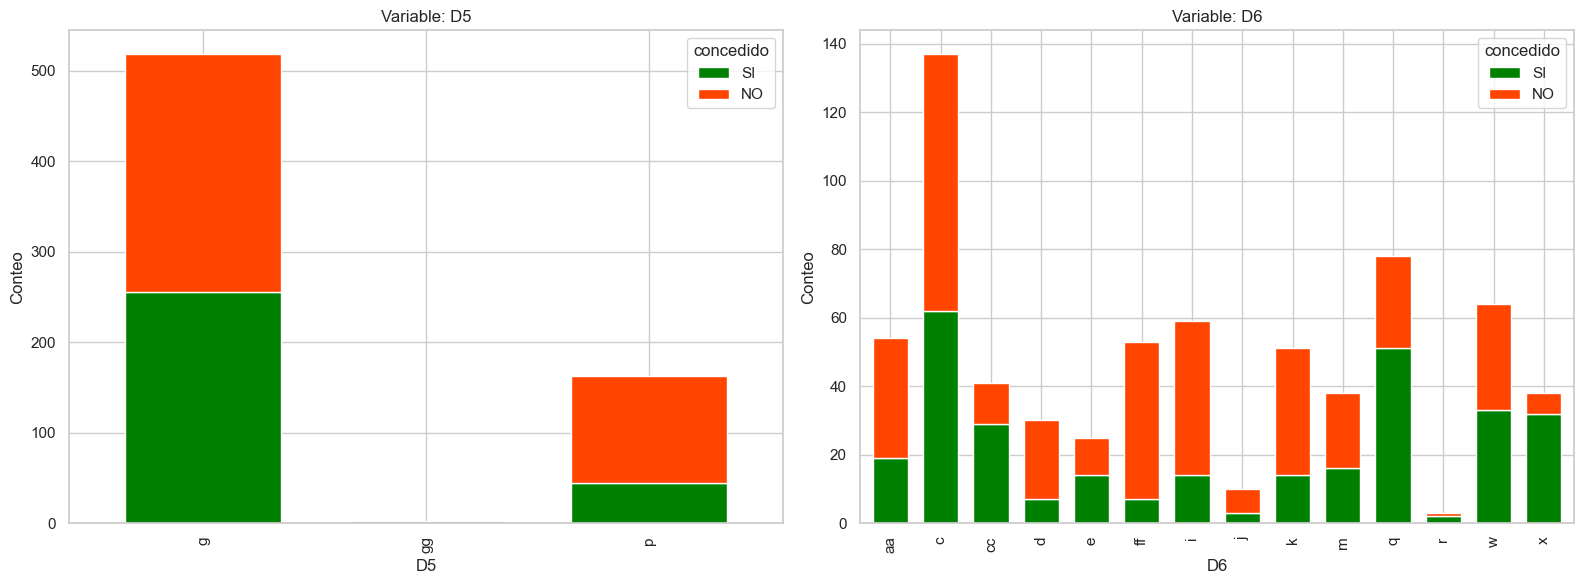


-- D7 --

Categoría: bb, NO=34, SI=25
Categoría: dd, NO=4, SI=2
Categoría: ff, NO=49, SI=8
Categoría: h, NO=51, SI=87
Categoría: j, NO=5, SI=3
Categoría: n, NO=2, SI=2
Categoría: o, NO=1, SI=1
Categoría: v, NO=230, SI=169
Categoría: z, NO=2, SI=6

-- D9 --

Categoría: f, NO=306, SI=23
Categoría: t, NO=77, SI=284


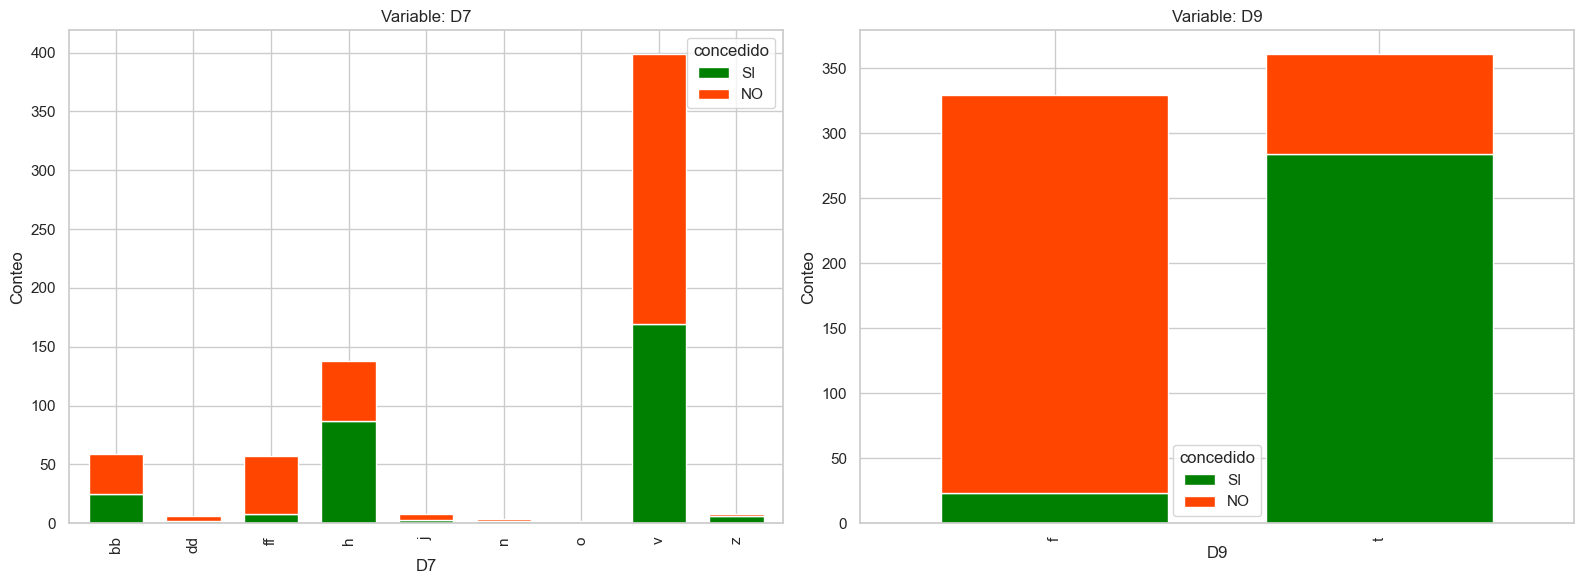


-- D10 --

Categoría: f, NO=297, SI=98
Categoría: t, NO=86, SI=209

-- D12 --

Categoría: f, NO=213, SI=161
Categoría: t, NO=170, SI=146


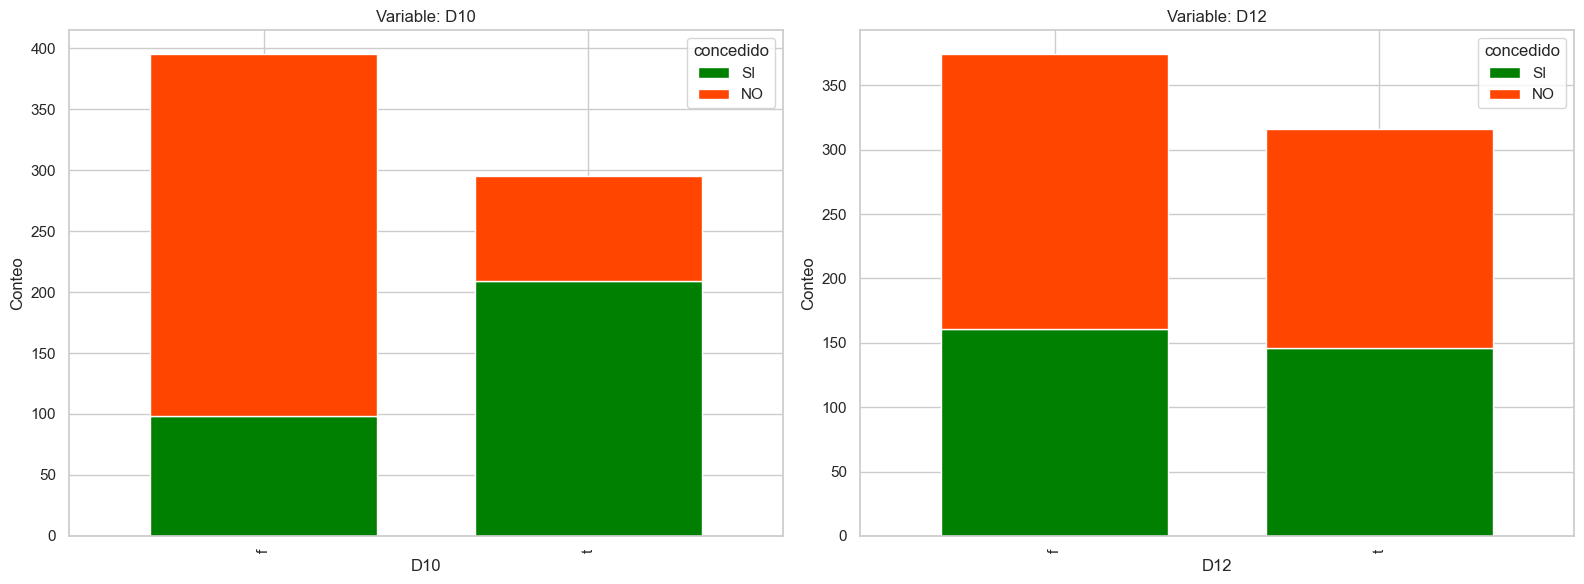


-- D13 --

Categoría: g, NO=338, SI=287
Categoría: p, NO=3, SI=5
Categoría: s, NO=42, SI=15


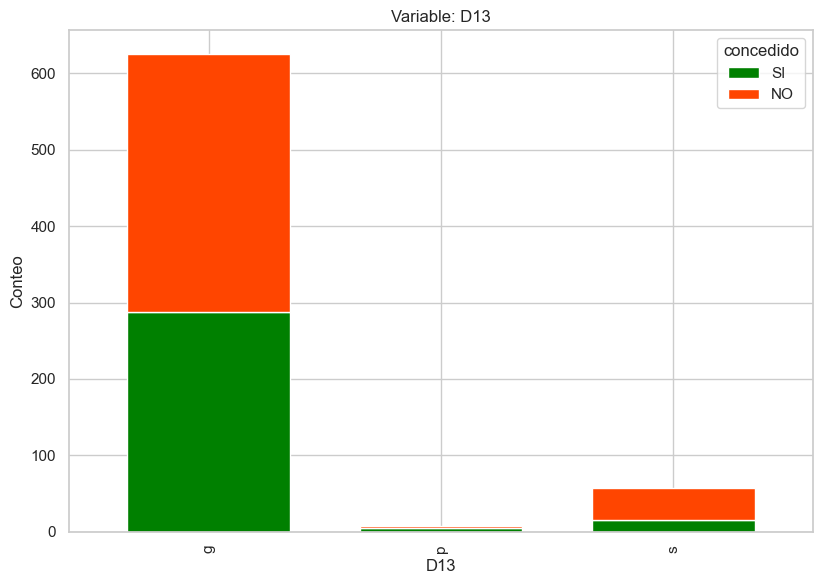

In [13]:


# Configuración de estilo
sns.set(style="whitegrid")

# Lista de variables categóricas
categorical_vars = tarjeta_credito.drop(columns='concedido').select_dtypes(include=["object"]).columns

# Iterar en pasos de 2 para agrupar las variables en pares
for i in range(0, len(categorical_vars), 2):
    # Crear una figura para cada par de variables
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Tamaño ajustado para que cada gráfico sea grande
    
    # Iterar sobre el par de variables y crear un gráfico para cada una
    for j in range(2):
        if i + j < len(categorical_vars):  # Verificar si el índice es válido
            var = categorical_vars[i + j]
            
            # Contar "NO" y "SI" para cada categoría de la variable
            counts = tarjeta_credito.groupby([var, 'concedido']).size().unstack(fill_value=0)
            no_count = counts.get('NO', pd.Series()).fillna(0).astype(int)  # Número de "NO"
            si_count = counts.get('SI', pd.Series()).fillna(0).astype(int)  # Número de "SI"

            # Determinar el orden de las barras: que el menor (SI o NO) esté arriba
            order = ['SI', 'NO'] if si_count.sum() < no_count.sum() else ['NO', 'SI']
            
            # Crear gráfico de barras apiladas
            counts = counts[order]  # Aseguramos que el orden correcto sea aplicado
            counts.plot(kind='bar', stacked=True, ax=axes[j], color=['green', 'orangered'], width=0.7)
            axes[j].set_title(f"Variable: {var}")
            axes[j].set_xlabel(var)
            axes[j].set_ylabel('Conteo')

            # Imprimir el conteo en la consola
            print(f"\n-- {var} --\n")  # Salto de línea al cambiar de variable
            for idx in counts.index:
                print(f"Categoría: {idx}, NO={no_count[idx]}, SI={si_count[idx]}")

        else:
            # Eliminar el subplot si no hay variable
            fig.delaxes(axes[j])

    # Ajustes finales y mostrar el gráfico
    plt.tight_layout()
    plt.show()







Podemos observar que las variables `D9` y `D10` presentan los mayores niveles de desequilibrio, lo que sugiere que podrían ser las más relevantes al momento de predecir si se concede o no el crédito.


# Modelos

## Adaboost

### Descripción y explicación de sus Hiperparámetros

**AdaBoost (Adaptive Boosting)** es un algoritmo de **ensemble learning** que combina varios modelos débiles  para crear un modelo robusto y fuerte. El algoritmo se basa en un enfoque iterativo donde cada nuevo modelo se entrena para corregir los errores cometidos por el modelo anterior. La idea principal de AdaBoost es ajustar el peso de las instancias en cada iteración, dándole mayor peso a aquellas que fueron mal clasificadas por los modelos anteriores.

#### Hiperparámetros de AdaBoostClassifier:

1. **`n_estimators`**: 
   - **Descripción**: Número de **estimadores** (modelos débiles) que se usarán en el ensemble de AdaBoost. A mayor número de estimadores, el modelo puede volverse más preciso, aunque también puede sufrir de **sobreajuste** si se elige un número demasiado alto.
   - **Valores con los que haremos el grid**: [50, 100, 150, 200, 250, 300, 350, 400, 450, 500].

2. **`learning_rate`**: 
   - **Descripción**: Tasa de aprendizaje que controla cuánto contribuye cada nuevo estimador (modelo débil) al modelo final. Un valor alto hará que los modelos débiles tengan más influencia, mientras que valores bajos hacen que su impacto sea más modesto.
   - **Valores con los que haremos el grid**: [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2].

3. **`algorithm`**:
   - **Descripción**: Algoritmo de combinación de modelos débiles. 
     - **`SAMME`** es el algoritmo original de AdaBoost, que ajusta los pesos de los modelos débiles usando una función exponencial de los errores.
     - **`SAMME.R`** es una variante más eficiente que usa una versión probabilística de los pesos.
   - **Valores con los que haremos el grid**: `['SAMME']`.


#### Evaluación del Modelo:
Una vez seleccionados los mejores hiperparámetros, el modelo es entrenado con esos parámetros óptimos y evaluado utilizando el conjunto de prueba. Se utilizan la **matriz de confusión** y el **reporte de clasificación** para evaluar el rendimiento del modelo, proporcionando métricas como precisión, exactitud, F1-score y recall.


### Dataset sin las filas con NA

Fitting 5 folds for each of 70 candidates, totalling 350 fits
Mejores hiperparámetros encontrados:
{'adaboost__algorithm': 'SAMME', 'adaboost__learning_rate': 0.25, 'adaboost__n_estimators': 100}
Puntuaciones de Validación Cruzada (5-fold): [0.9047619  0.87619048 0.85576923 0.84615385 0.85576923]
Promedio de Validación Cruzada: 0.8677289377289377


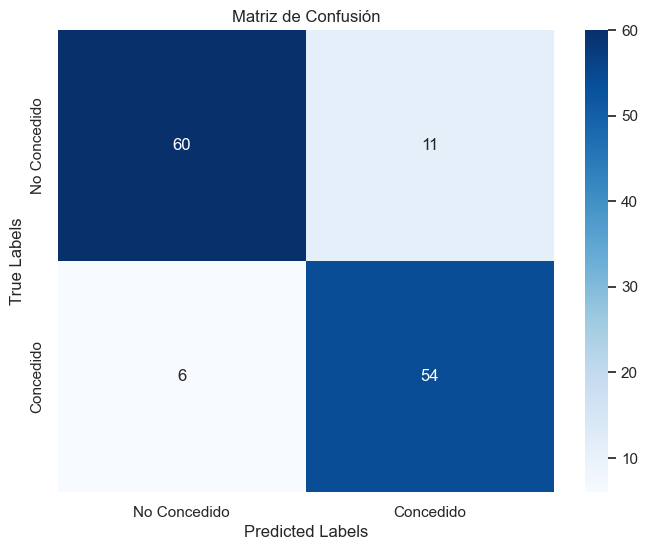

Reporte de Clasificación en conjunto de prueba:
              precision    recall  f1-score   support

          NO       0.91      0.85      0.88        71
          SI       0.83      0.90      0.86        60

    accuracy                           0.87       131
   macro avg       0.87      0.87      0.87       131
weighted avg       0.87      0.87      0.87       131

Rendimiento en conjunto de entrenamiento (cv): 0.8677289377289377
Rendimiento en conjunto de prueba: 0.8702290076335878


In [ ]:
# Eliminar filas con valores NA en el dataset completo
tarjeta_credito_clean = tarjeta_credito.dropna()

# Dividir el dataset limpio en características (X) y objetivo (y)
X = tarjeta_credito_clean.drop(columns='concedido')
y = tarjeta_credito_clean['concedido']

# Dividir el dataset limpio en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=semilla)

# Identificar columnas categóricas y numéricas
cat_features = X.select_dtypes(include=['object']).columns  # Variables categóricas
num_features = X.select_dtypes(include=['int64', 'float64']).columns  # Variables numéricas

# Paso de preprocesamiento para variables categóricas y numéricas
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),  # One-Hot Encoding para categóricas
    ('num', 'passthrough', num_features)  # Pasar las numéricas sin cambios
])

# Crear el pipeline base
adaboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('adaboost', AdaBoostClassifier(random_state=semilla))  # Modelo AdaBoost
])

# Hiperparámetros para buscar
param_grid = {
    'adaboost__n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],  # Número de árboles
    'adaboost__learning_rate': [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2],  # Tasa de aprendizaje
    'adaboost__algorithm': ['SAMME']  # Algoritmos
}

# Realizar la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=adaboost_pipeline, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Realizar la validación cruzada en el conjunto de entrenamiento
cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')

# Promedio de las puntuaciones de validación cruzada
print("Puntuaciones de Validación Cruzada (5-fold):", cv_scores)
print("Promedio de Validación Cruzada:", cv_scores.mean())

# Guardar el mejor modelo encontrado
joblib.dump(grid_search.best_estimator_, ruta_modelos_adaboost + 'modelo_adaboost_sin_filas_na.pkl')

# Evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Concedido', 'Concedido'], yticklabels=['No Concedido', 'Concedido'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matriz de Confusión')
plt.show()

# Reporte de clasificación
print("Reporte de Clasificación en conjunto de prueba:")
print(classification_report(y_test, y_pred))

# Comparar el rendimiento en el conjunto de entrenamiento (validación cruzada) y el conjunto de prueba
train_accuracy = cv_scores.mean()
test_accuracy = classification_report(y_test, y_pred, output_dict=True)['accuracy']

print(f"Rendimiento en conjunto de entrenamiento (cv): {train_accuracy}")
print(f"Rendimiento en conjunto de test: {test_accuracy}")


### Dataset con media y moda donde haya valores NA

Fitting 5 folds for each of 70 candidates, totalling 350 fits
Mejores hiperparámetros encontrados:
{'adaboost__algorithm': 'SAMME', 'adaboost__learning_rate': 0.25, 'adaboost__n_estimators': 400}
Puntuaciones de Validación Cruzada (5-fold): [0.9009009  0.83783784 0.88181818 0.82727273 0.85454545]
Promedio de Validación Cruzada: 0.8604750204750203


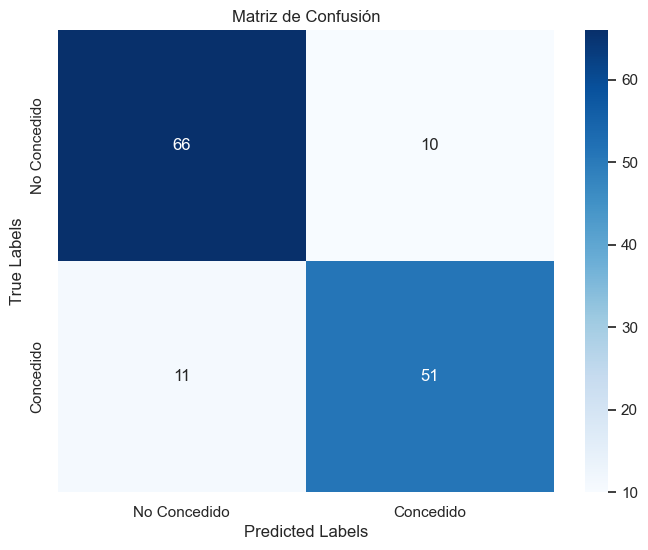

Reporte de Clasificación en conjunto de prueba:
              precision    recall  f1-score   support

          NO       0.86      0.87      0.86        76
          SI       0.84      0.82      0.83        62

    accuracy                           0.85       138
   macro avg       0.85      0.85      0.85       138
weighted avg       0.85      0.85      0.85       138

Rendimiento en conjunto de entrenamiento (cv): 0.8604750204750203
Rendimiento en conjunto de test: 0.8478260869565217


In [ ]:
# Imputar valores faltantes
# Dividir el dataset en características (X) y objetivo (y)
X = tarjeta_credito.drop(columns='concedido')
y = tarjeta_credito['concedido']

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=semilla)

# Identificar columnas categóricas y numéricas
cat_features = X.select_dtypes(include=['object']).columns  # Variables categóricas
num_features = X.select_dtypes(include=['int64', 'float64']).columns  # Variables numéricas

# Paso de preprocesamiento para variables categóricas y numéricas
preprocessor = ColumnTransformer([
    # Imputación y codificación para variables categóricas
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con moda
        ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-Hot Encoding
    ]), cat_features),
    
    # Imputación para numéricas
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Imputar con la media
        ('passthrough', 'passthrough')  # Pasar las numéricas sin cambios
    ]), num_features)
])

# Crear el pipeline base
adaboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('adaboost', AdaBoostClassifier(random_state=semilla))  # Modelo AdaBoost
])

# Hiperparámetros para buscar
param_grid = {
    'adaboost__n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],  # Número de árboles
    'adaboost__learning_rate': [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2],  # Tasa de aprendizaje
    'adaboost__algorithm': ['SAMME']  # Algoritmos
}

# Realizar la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=adaboost_pipeline, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Realizar la validación cruzada en el conjunto de entrenamiento
cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')

# Promedio de las puntuaciones de validación cruzada
print("Puntuaciones de Validación Cruzada (5-fold):", cv_scores)
print("Promedio de Validación Cruzada:", cv_scores.mean())

# Guardar el modelo
joblib.dump(grid_search.best_estimator_, ruta_modelos_adaboost + 'modelo_adaboost_con_imputacion.pkl')

# Evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Concedido', 'Concedido'], yticklabels=['No Concedido', 'Concedido'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matriz de Confusión')
plt.show()

# Reporte de clasificación
print("Reporte de Clasificación en conjunto de prueba:")
print(classification_report(y_test, y_pred))

# Comparar el rendimiento en el conjunto de entrenamiento (validación cruzada) y el conjunto de prueba
train_accuracy = cv_scores.mean()
test_accuracy = classification_report(y_test, y_pred, output_dict=True)['accuracy']

print(f"Rendimiento en conjunto de entrenamiento (cv): {train_accuracy}")
print(f"Rendimiento en conjunto de test: {test_accuracy}")



### Dataset con knn-vecinos donde haya valores NA

Fitting 5 folds for each of 70 candidates, totalling 350 fits
Mejores hiperparámetros encontrados:
{'adaboost__algorithm': 'SAMME', 'adaboost__learning_rate': 0.25, 'adaboost__n_estimators': 450}
Puntuaciones de Validación Cruzada (5-fold): [0.9009009  0.84684685 0.88181818 0.83636364 0.85454545]
Promedio de Validación Cruzada: 0.8640950040950042


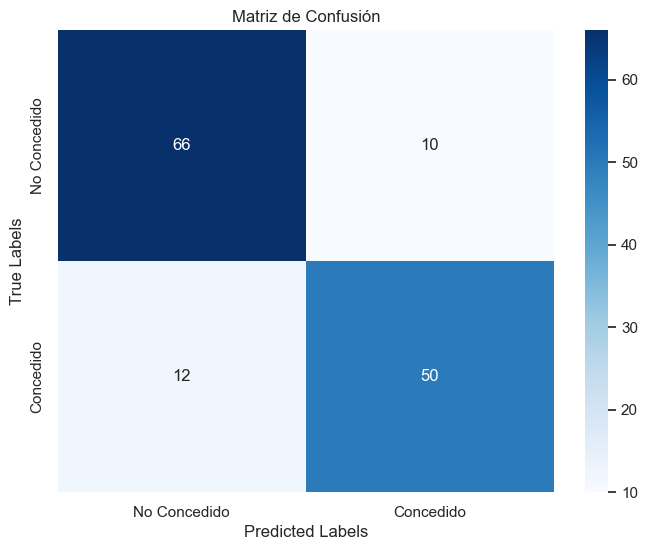

Reporte de Clasificación en conjunto de prueba:
              precision    recall  f1-score   support

          NO       0.85      0.87      0.86        76
          SI       0.83      0.81      0.82        62

    accuracy                           0.84       138
   macro avg       0.84      0.84      0.84       138
weighted avg       0.84      0.84      0.84       138

Rendimiento en conjunto de entrenamiento (cv): 0.8640950040950042
Rendimiento en conjunto de test: 0.8405797101449275


In [ ]:
# Dividir el dataset en características (X) y objetivo (y)
X = tarjeta_credito.drop(columns='concedido')
y = tarjeta_credito['concedido']

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=semilla)

# Identificar columnas categóricas y numéricas
cat_features = X.select_dtypes(include=['object']).columns  # Variables categóricas
num_features = X.select_dtypes(include=['int64', 'float64']).columns  # Variables numéricas

# Paso de preprocesamiento para variables categóricas y numéricas
preprocessor = ColumnTransformer([
    # Imputación y codificación para variables categóricas
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con el valor más frecuente
        ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-Hot Encoding
    ]), cat_features),
    
    # Imputación para variables numéricas
    ('num', Pipeline([
        ('imputer', KNNImputer(n_neighbors=5, weights='uniform')),  # Imputar con k-vecinos
    ]), num_features)
])

# Crear el pipeline base
adaboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('adaboost', AdaBoostClassifier(random_state=semilla))  # Modelo AdaBoost
])

# Hiperparámetros para buscar
param_grid = {
    'adaboost__n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],  # Número de árboles
    'adaboost__learning_rate': [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2],  # Tasa de aprendizaje
    'adaboost__algorithm': ['SAMME']  # Algoritmos
}

# Realizar la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=adaboost_pipeline, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Realizar la validación cruzada en el conjunto de entrenamiento
cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')

# Promedio de las puntuaciones de validación cruzada
print("Puntuaciones de Validación Cruzada (5-fold):", cv_scores)
print("Promedio de Validación Cruzada:", cv_scores.mean())

# Guardar el modelo
joblib.dump(grid_search.best_estimator_, ruta_modelos_adaboost + 'modelo_adaboost_knn_imputer.pkl')

# Evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Concedido', 'Concedido'], yticklabels=['No Concedido', 'Concedido'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matriz de Confusión')
plt.show()

# Reporte de clasificación
print("Reporte de Clasificación en conjunto de prueba:")
print(classification_report(y_test, y_pred))

# Comparar el rendimiento en el conjunto de entrenamiento (validación cruzada) y el conjunto de prueba
train_accuracy = cv_scores.mean()
test_accuracy = classification_report(y_test, y_pred, output_dict=True)['accuracy']

print(f"Rendimiento en conjunto de entrenamiento (cv): {train_accuracy}")
print(f"Rendimiento en conjunto de test: {test_accuracy}")


## Random Forest

### Descripción de Random Forest y sus Hiperparámetros

**Random Forest** es un algoritmo de **ensemble learning** que utiliza varios **árboles de decisión** para mejorar la precisión y robustez del modelo. Cada árbol se entrena con una muestra aleatoria de los datos y realiza predicciones, y el modelo final se obtiene tomando el promedio (en el caso de regresión) o la mayoría de votos (en el caso de clasificación) de todos los árboles.


#### Hiperparámetros de RandomForestClassifier:

1. **`n_estimators`**: 
   - **Descripción**: Número de **árboles de decisión** en el bosque. Un número mayor de árboles puede mejorar la precisión, pero también aumenta el costo computacional.
   - **Valores con los que haremos el grid**: [50, 100, 200, 300, 400].

2. **`max_features`**:
   - **Descripción**: Número máximo de características a considerar al dividir un nodo. 
     - **`sqrt`**: La raíz cuadrada del número total de características.
     - **`log2`**: El logaritmo en base 2 del número total de características.
   - **Valores con los que haremos el grid**: `['sqrt', 'log2']`.

3. **`criterion`**:
   - **Descripción**: La función utilizada para medir la calidad de las divisiones en los árboles. 
     - **`gini`**: Índice de Gini, mide la impureza de las divisiones.
     - **`entropy`**: Entropía, mide la ganancia de información en cada división.
     - **`log_loss`**: Pérdida logarítmica, comúnmente usada en problemas probabilísticos.
   - **Valores con los que haremos el grid**: `['gini', 'entropy', 'log_loss']`.

4. **`max_depth`**:
   - **Descripción**: Profundidad máxima de los árboles de decisión. Limitar la profundidad ayuda a evitar el sobreajuste.
   - **Valores con los que haremos el grid**: `[None, 10, 20, 30, 40]`.

5. **`min_samples_split`**:
   - **Descripción**: Número mínimo de muestras necesarias para dividir un nodo.
   - **Valores con los que haremos el grid**: `[2, 5, 10]`.

6. **`min_samples_leaf`**:
   - **Descripción**: Número mínimo de muestras necesarias para estar en una hoja.
   - **Valores con los que haremos el grid**: `[1, 2, 4]`.

7. **`bootstrap`**:
   - **Descripción**: Controla si se realiza **muestreo con reemplazo** para entrenar cada árbol.
     - **`True`**: Con muestreo con reemplazo.
     - **`False`**: Sin muestreo con reemplazo.
   - **Valores con los que haremos el grid**: `[True, False]`.



#### Evaluación del Modelo:
El modelo se evalúa utilizando el conjunto de prueba. Se emplean la **matriz de confusión** y el **reporte de clasificación** para medir el rendimiento del modelo, proporcionando métricas como la precisión, exactitud, F1-score y recall.


### Dataset sin las filas con NA

Fitting 5 folds for each of 2700 candidates, totalling 13500 fits
Mejores hiperparámetros encontrados:
{'randomforest__bootstrap': True, 'randomforest__criterion': 'entropy', 'randomforest__max_depth': None, 'randomforest__max_features': 'log2', 'randomforest__min_samples_leaf': 4, 'randomforest__min_samples_split': 2, 'randomforest__n_estimators': 50}


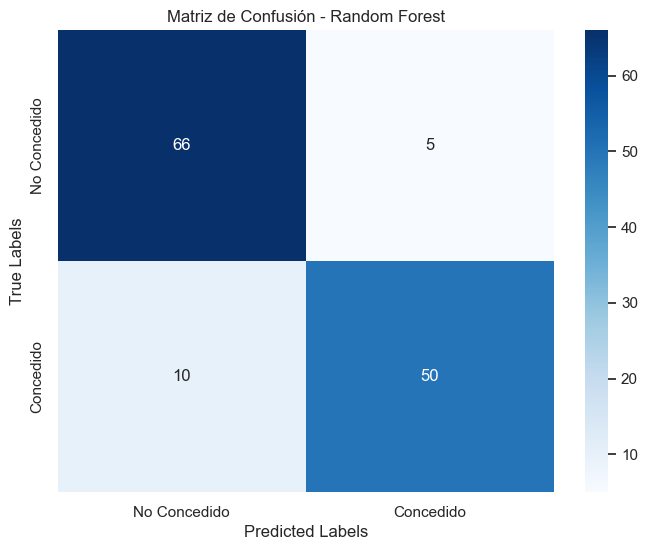

Reporte de Clasificación:
              precision    recall  f1-score   support

          NO       0.87      0.93      0.90        71
          SI       0.91      0.83      0.87        60

    accuracy                           0.89       131
   macro avg       0.89      0.88      0.88       131
weighted avg       0.89      0.89      0.88       131



In [ ]:
# Manejo de valores faltantes (NA)
# Eliminar filas con NAs (alternativamente, se puede usar imputación)
tarjeta_credito_clean = tarjeta_credito.dropna()

# Dividir el dataset en características (X) y objetivo (y)
X = tarjeta_credito_clean.drop(columns='concedido')
y = tarjeta_credito_clean['concedido']

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=semilla)

# Identificar columnas categóricas y numéricas
cat_features = X.select_dtypes(include=['object']).columns  # Variables categóricas
num_features = X.select_dtypes(include=['int64', 'float64']).columns  # Variables numéricas

# Paso de preprocesamiento solo para variables categóricas
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Codificación de categóricas
], remainder='passthrough')  # Dejar las numéricas sin tocar

# Crear el pipeline base
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('randomforest', RandomForestClassifier(random_state=semilla))  # Modelo Random Forest
])

# Hiperparámetros para buscar
param_grid = {
    'randomforest__n_estimators': [50, 100, 200, 300, 400],  # Número de árboles
    'randomforest__max_features': ['sqrt', 'log2'],  # Número máximo de características
    'randomforest__criterion': ['gini', 'entropy', 'log_loss'],  # Criterio de división
    'randomforest__max_depth': [None, 10, 20, 30, 40],  # Profundidad máxima
    'randomforest__min_samples_split': [2, 5, 10],  # Tamaño mínimo para dividir
    'randomforest__min_samples_leaf': [1, 2, 4],  # Tamaño mínimo de hojas
    'randomforest__bootstrap': [True, False]  # Con o sin remuestreo
}

# Realizar la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Guardar el modelo
joblib.dump(grid_search.best_estimator_,  ruta_modelos_rf + 'modelo_rf_sin_filas_na.pkl')

# Evaluar el modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Concedido', 'Concedido'], yticklabels=['No Concedido', 'Concedido'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matriz de Confusión - Random Forest')
plt.show()

# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))



In [14]:
#Cargamos el modelo anteriormente guardado y hacemos tanto cross-validation como prediccion
tarjeta_credito_clean = tarjeta_credito.dropna()

# Dividir el dataset en características (X) y objetivo (y)
X = tarjeta_credito_clean.drop(columns='concedido')
y = tarjeta_credito_clean['concedido']

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=semilla)
# Cargar el modelo
modelo_rf = joblib.load(ruta_modelos_rf + 'modelo_rf_sin_filas_na.pkl')

# Realizar la validación cruzada en el conjunto de entrenamiento
cv_scores = cross_val_score(modelo_rf, X_train, y_train, cv=5, scoring='accuracy')

# Promedio de las puntuaciones de validación cruzada
print("Puntuaciones de Validación Cruzada (5-fold):", cv_scores)
print("Promedio de Validación Cruzada:", cv_scores.mean())

# Evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba
y_pred = modelo_rf.predict(X_test)

print(f"La predicción es: {accuracy_score(y_test, y_pred)}")

Puntuaciones de Validación Cruzada (5-fold): [0.92380952 0.86666667 0.86538462 0.88461538 0.86538462]
Promedio de Validación Cruzada: 0.8811721611721612
La predicción es: 0.8854961832061069


### Dataset con media y moda donde haya valores NA

Fitting 5 folds for each of 2700 candidates, totalling 13500 fits
[CV] END randomforest__bootstrap=True, randomforest__criterion=gini, randomforest__max_depth=None, randomforest__max_features=sqrt, randomforest__min_samples_leaf=1, randomforest__min_samples_split=2, randomforest__n_estimators=50; total time=   0.0s
[CV] END randomforest__bootstrap=True, randomforest__criterion=gini, randomforest__max_depth=None, randomforest__max_features=sqrt, randomforest__min_samples_leaf=1, randomforest__min_samples_split=2, randomforest__n_estimators=50; total time=   0.0s
[CV] END randomforest__bootstrap=True, randomforest__criterion=gini, randomforest__max_depth=None, randomforest__max_features=sqrt, randomforest__min_samples_leaf=1, randomforest__min_samples_split=2, randomforest__n_estimators=50; total time=   0.0s
[CV] END randomforest__bootstrap=True, randomforest__criterion=gini, randomforest__max_depth=None, randomforest__max_features=sqrt, randomforest__min_samples_leaf=1, randomforest__m

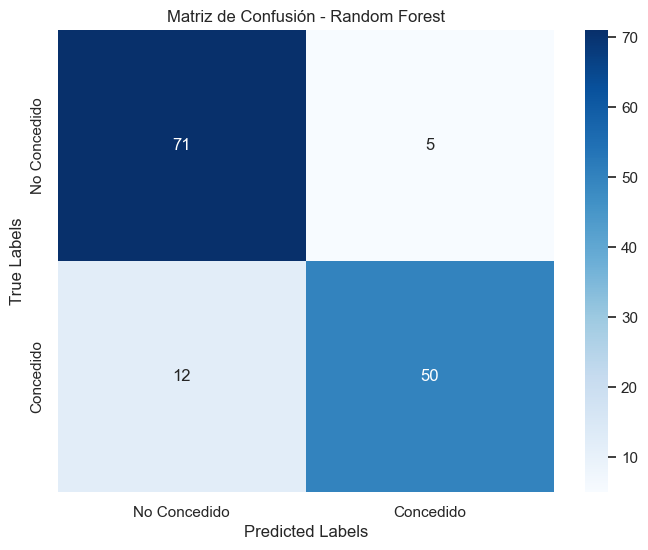

Reporte de Clasificación:
              precision    recall  f1-score   support

          NO       0.86      0.93      0.89        76
          SI       0.91      0.81      0.85        62

    accuracy                           0.88       138
   macro avg       0.88      0.87      0.87       138
weighted avg       0.88      0.88      0.88       138



In [ ]:
# Dividir el dataset en características (X) y objetivo (y)
X = tarjeta_credito.drop(columns='concedido')
y = tarjeta_credito['concedido']

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=semilla)

# Identificar columnas categóricas y numéricas
cat_features = X.select_dtypes(include=['object']).columns  # Variables categóricas
num_features = X.select_dtypes(include=['int64', 'float64']).columns  # Variables numéricas

# Paso de preprocesamiento para variables categóricas y numéricas
preprocessor = ColumnTransformer([
    # Imputación y codificación para variables categóricas
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con la moda
        ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-Hot Encoding
    ]), cat_features),
    
    # Imputación para variables numéricas
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Imputar con la media
        ('passthrough', 'passthrough')  # Pasar las numéricas sin cambios
    ]), num_features)
])

# Crear el pipeline base con RandomForestClassifier
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('randomforest', RandomForestClassifier(random_state=semilla))  # Modelo Random Forest
])

# Hiperparámetros para búsqueda
param_grid = {
    'randomforest__n_estimators': [50, 100, 200, 300, 400],  # Número de árboles
    'randomforest__max_features': ['sqrt', 'log2'],  # Número máximo de características
    'randomforest__criterion': ['gini', 'entropy', 'log_loss'],  # Criterio de división
    'randomforest__max_depth': [None, 10, 20, 30, 40],  # Profundidad máxima
    'randomforest__min_samples_split': [2, 5, 10],  # Tamaño mínimo para dividir
    'randomforest__min_samples_leaf': [1, 2, 4],  # Tamaño mínimo de hojas
    'randomforest__bootstrap': [True, False]  # Con o sin remuestreo
}

# Realizar la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Guardar el modelo
joblib.dump(grid_search.best_estimator_, ruta_modelos_rf + 'modelo_rf_con_imputacion.pkl')

# Evaluar el modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Concedido', 'Concedido'], yticklabels=['No Concedido', 'Concedido'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matriz de Confusión - Random Forest')
plt.show()

# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))


In [ ]:
# Dividir el dataset en características (X) y objetivo (y)
X = tarjeta_credito.drop(columns='concedido')
y = tarjeta_credito['concedido']

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=semilla)
# Cargar el modelo
modelo_rf = joblib.load(ruta_modelos_rf + 'modelo_rf_con_imputacion.pkl')

# Realizar la validación cruzada en el conjunto de entrenamiento
cv_scores = cross_val_score(modelo_rf, X_train, y_train, cv=5, scoring='accuracy')

# Promedio de las puntuaciones de validación cruzada
print("Puntuaciones de Validación Cruzada (5-fold):", cv_scores)
print("Promedio de Validación Cruzada:", cv_scores.mean())

# Evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba
y_pred = modelo_rf.predict(X_test)

print(f"La predicción es: {accuracy_score(y_test, y_pred)}")

Puntuaciones de Validación Cruzada (5-fold): [0.91891892 0.87387387 0.89090909 0.86363636 0.88181818]
Promedio de Validación Cruzada: 0.8858312858312857
La predicción es: 0.8768115942028986


### Dataset con knn-vecinos donde haya valores NA

Fitting 5 folds for each of 2700 candidates, totalling 13500 fits
[CV] END randomforest__bootstrap=True, randomforest__criterion=gini, randomforest__max_depth=None, randomforest__max_features=sqrt, randomforest__min_samples_leaf=1, randomforest__min_samples_split=2, randomforest__n_estimators=50; total time=   0.0s
[CV] END randomforest__bootstrap=True, randomforest__criterion=gini, randomforest__max_depth=None, randomforest__max_features=sqrt, randomforest__min_samples_leaf=1, randomforest__min_samples_split=2, randomforest__n_estimators=50; total time=   0.0s
[CV] END randomforest__bootstrap=True, randomforest__criterion=gini, randomforest__max_depth=None, randomforest__max_features=sqrt, randomforest__min_samples_leaf=1, randomforest__min_samples_split=2, randomforest__n_estimators=50; total time=   0.0s
[CV] END randomforest__bootstrap=True, randomforest__criterion=gini, randomforest__max_depth=None, randomforest__max_features=sqrt, randomforest__min_samples_leaf=1, randomforest__m

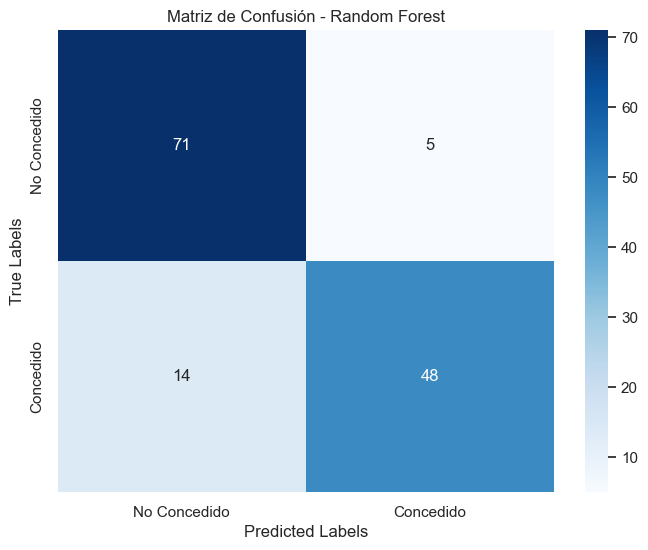

Reporte de Clasificación:
              precision    recall  f1-score   support

          NO       0.84      0.93      0.88        76
          SI       0.91      0.77      0.83        62

    accuracy                           0.86       138
   macro avg       0.87      0.85      0.86       138
weighted avg       0.87      0.86      0.86       138



In [ ]:
# Dividir el dataset en características (X) y objetivo (y)
X = tarjeta_credito.drop(columns='concedido')
y = tarjeta_credito['concedido']

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=semilla)

# Identificar columnas categóricas y numéricas
cat_features = X.select_dtypes(include=['object']).columns  # Variables categóricas
num_features = X.select_dtypes(include=['int64', 'float64']).columns  # Variables numéricas

# Paso de preprocesamiento para variables categóricas y numéricas
preprocessor = ColumnTransformer([
    # Imputación y codificación para variables categóricas
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con la moda
        ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-Hot Encoding
    ]), cat_features),
    
    # Imputación para variables numéricas con KNNImputer
    ('num', Pipeline([
        ('imputer', KNNImputer(n_neighbors=5, weights='uniform')),  # Imputar con KNN
        ('passthrough', 'passthrough')  # Dejar las variables numéricas sin más cambios
    ]), num_features)
])

# Crear el pipeline base con RandomForestClassifier
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('randomforest', RandomForestClassifier(random_state=semilla))  # Modelo Random Forest
])

# Hiperparámetros para búsqueda
param_grid = {
    'randomforest__n_estimators': [50, 100, 200, 300, 400],  # Número de árboles
    'randomforest__max_features': ['sqrt', 'log2'],  # Número máximo de características
    'randomforest__criterion': ['gini', 'entropy', 'log_loss'],  # Criterio de división
    'randomforest__max_depth': [None, 10, 20, 30, 40],  # Profundidad máxima
    'randomforest__min_samples_split': [2, 5, 10],  # Tamaño mínimo para dividir
    'randomforest__min_samples_leaf': [1, 2, 4],  # Tamaño mínimo de hojas
    'randomforest__bootstrap': [True, False]  # Con o sin remuestreo
}

# Realizar la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Guardar el modelo
joblib.dump(grid_search.best_estimator_, ruta_modelos_rf + 'modelo_rf_knn_imputer.pkl')

# Evaluar el modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Concedido', 'Concedido'], yticklabels=['No Concedido', 'Concedido'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matriz de Confusión - Random Forest')
plt.show()

# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))


In [15]:
# Dividir el dataset en características (X) y objetivo (y)
X = tarjeta_credito.drop(columns='concedido')
y = tarjeta_credito['concedido']

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=semilla)
# Cargar el modelo
modelo_rf = joblib.load(ruta_modelos_rf + 'modelo_rf_knn_imputer.pkl')

# Realizar la validación cruzada en el conjunto de entrenamiento
cv_scores = cross_val_score(modelo_rf, X_train, y_train, cv=5, scoring='accuracy')

# Promedio de las puntuaciones de validación cruzada
print("Puntuaciones de Validación Cruzada (5-fold):", cv_scores)
print("Promedio de Validación Cruzada:", cv_scores.mean())

# Evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba
y_pred = modelo_rf.predict(X_test)

print(f"La predicción es: {accuracy_score(y_test, y_pred)}")

Puntuaciones de Validación Cruzada (5-fold): [0.93693694 0.86486486 0.90909091 0.85454545 0.87272727]
Promedio de Validación Cruzada: 0.8876330876330876
La predicción es: 0.8623188405797102


## Stacking

### Descripción de Stacking y sus Hiperparámetros

**Stacking** es un método de **ensemble learning** que combina varios modelos base para mejorar el rendimiento del modelo. A diferencia de otros métodos como **bagging** o **boosting**, el stacking utiliza un **modelo meta** para aprender a combinar las predicciones de los modelos base de manera más eficiente.

#### Componentes del Stacking:

1. **Modelos base (estimadores de nivel 0)**:
   - **Random Forest**: Algoritmo que utiliza varios árboles de decisión para obtener una predicción.
   - **AdaBoost**: Un modelo de boosting que ajusta los pesos de los errores cometidos en los modelos anteriores.
   - **Gradient Boosting**: Un algoritmo de boosting que optimiza el modelo secuencialmente para corregir errores previos.

2. **Modelo meta**:
   - **Logistic Regression**: Un clasificador que combina las predicciones de los modelos base para hacer una predicción final.


### Dataset sin las filas con NA

Puntuaciones de Validación Cruzada (5-fold): [0.8952381  0.84761905 0.86538462 0.84615385 0.875     ]
Promedio de Validación Cruzada: 0.8658791208791209


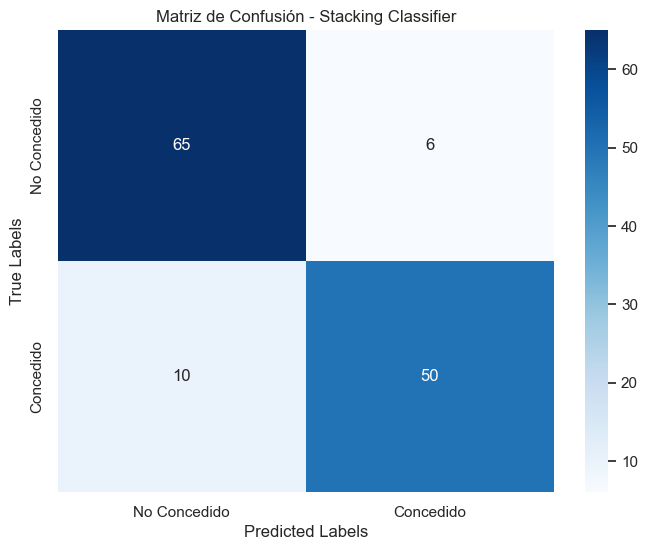

Reporte de Clasificación en conjunto de prueba:
              precision    recall  f1-score   support

          NO       0.87      0.92      0.89        71
          SI       0.89      0.83      0.86        60

    accuracy                           0.88       131
   macro avg       0.88      0.87      0.88       131
weighted avg       0.88      0.88      0.88       131

Rendimiento en conjunto de entrenamiento (cv): 0.8658791208791209
Rendimiento en conjunto de test: 0.8778625954198473


In [ ]:
# Manejo de valores faltantes (NA)
# Eliminar filas con NAs
tarjeta_credito_clean = tarjeta_credito.dropna()

# Dividir el dataset en características (X) y objetivo (y)
X = tarjeta_credito_clean.drop(columns='concedido')
y = tarjeta_credito_clean['concedido']

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=semilla)

# Identificar columnas categóricas y numéricas
cat_features = X.select_dtypes(include=['object']).columns  # Variables categóricas
num_features = X.select_dtypes(include=['int64', 'float64']).columns  # Variables numéricas

# Paso de preprocesamiento para variables categóricas
preprocessor = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)], remainder='passthrough')

# Crear pipelines para clasificadores base
rf_pipeline = Pipeline([('preprocessor', preprocessor), ('randomforest', RandomForestClassifier(n_estimators=100, random_state=semilla))])

# Configurar AdaBoost con algoritmo SAMME
ada_pipeline = Pipeline([('preprocessor', preprocessor), ('adaboost', AdaBoostClassifier(n_estimators=100, algorithm='SAMME', random_state=semilla))])

gb_pipeline = Pipeline([('preprocessor', preprocessor), ('gradientboost', GradientBoostingClassifier(n_estimators=100, random_state=semilla))])

# Clasificador meta
meta_model = LogisticRegression(random_state=semilla)

# Crear el StackingClassifier
stacking_model = StackingClassifier(
    estimators=[
        ('random_forest', rf_pipeline),
        ('adaboost', ada_pipeline),
        ('gradient_boosting', gb_pipeline),
    ],
    final_estimator=meta_model,
    cv=5  # Validación cruzada con 5 pliegues
)

# Realizar la validación cruzada en el conjunto de entrenamiento
cv_scores = cross_val_score(stacking_model, X_train, y_train, cv=5, scoring='accuracy')

# Promedio de las puntuaciones de validación cruzada
print("Puntuaciones de Validación Cruzada (5-fold):", cv_scores)
print("Promedio de Validación Cruzada:", cv_scores.mean())

# Ajustar el modelo Stacking en el conjunto de entrenamiento
stacking_model.fit(X_train, y_train)

# Guardar el modelo
joblib.dump(stacking_model, ruta_modelos_stacking + 'modelo_stacking_sin_filas_na.pkl')

# Realizar predicciones en el conjunto de prueba y evaluar
y_pred = stacking_model.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Concedido', 'Concedido'], yticklabels=['No Concedido', 'Concedido'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matriz de Confusión - Stacking Classifier')
plt.show()

# Reporte de clasificación
print("Reporte de Clasificación en conjunto de prueba:")
print(classification_report(y_test, y_pred))

# Comparar rendimiento en el conjunto de entrenamiento con el de validación cruzada
train_accuracy = cv_scores.mean()
test_accuracy = classification_report(y_test, y_pred, output_dict=True)['accuracy']

print(f"Rendimiento en conjunto de entrenamiento (cv): {train_accuracy}")
print(f"Rendimiento en conjunto de test: {test_accuracy}")




### Dataset con media y moda donde haya valores NA

Puntuaciones de Validación Cruzada (5-fold): [0.9009009  0.85585586 0.88181818 0.83636364 0.86363636]
Promedio de Validación Cruzada: 0.8677149877149878


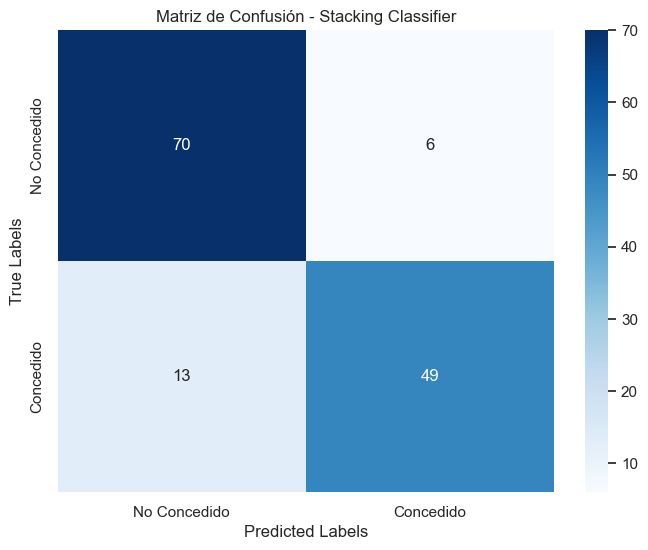

Reporte de Clasificación en conjunto de prueba:
              precision    recall  f1-score   support

          NO       0.84      0.92      0.88        76
          SI       0.89      0.79      0.84        62

    accuracy                           0.86       138
   macro avg       0.87      0.86      0.86       138
weighted avg       0.86      0.86      0.86       138

Rendimiento en conjunto de entrenamiento (cv): 0.8677149877149878
Rendimiento en conjunto de test: 0.8623188405797102


In [ ]:
from sklearn.model_selection import cross_val_score

# Dividir el dataset en características (X) y objetivo (y)
X = tarjeta_credito.drop(columns='concedido')
y = tarjeta_credito['concedido']

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=semilla)

# Identificar columnas categóricas y numéricas
cat_features = X.select_dtypes(include=['object']).columns  # Variables categóricas
num_features = X.select_dtypes(include=['int64', 'float64']).columns  # Variables numéricas

# Paso de preprocesamiento para variables categóricas y numéricas
preprocessor = ColumnTransformer([
    # Imputación y codificación para variables categóricas
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con la moda
        ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-Hot Encoding
    ]), cat_features),
    
    # Imputación para variables numéricas
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Imputar con la media
        ('passthrough', 'passthrough')  # Pasar las numéricas sin cambios
    ]), num_features)
])

# Crear pipelines para clasificadores base
rf_pipeline = Pipeline([('preprocessor', preprocessor), 
                        ('randomforest', RandomForestClassifier(n_estimators=100, random_state=semilla))])

# Configurar AdaBoost con algoritmo SAMME
ada_pipeline = Pipeline([('preprocessor', preprocessor), 
                         ('adaboost', AdaBoostClassifier(n_estimators=100, algorithm='SAMME', random_state=semilla))])

gb_pipeline = Pipeline([('preprocessor', preprocessor), 
                        ('gradientboost', GradientBoostingClassifier(n_estimators=100, random_state=semilla))])

# Clasificador meta
meta_model = LogisticRegression(random_state=semilla)

# Crear el StackingClassifier
stacking_model = StackingClassifier(
    estimators=[
        ('random_forest', rf_pipeline),
        ('adaboost', ada_pipeline),
        ('gradient_boosting', gb_pipeline),
    ],
    final_estimator=meta_model,
    cv=5
)

# Realizar la validación cruzada en el conjunto de entrenamiento
cv_scores = cross_val_score(stacking_model, X_train, y_train, cv=5, scoring='accuracy')

# Promedio de las puntuaciones de validación cruzada
print("Puntuaciones de Validación Cruzada (5-fold):", cv_scores)
print("Promedio de Validación Cruzada:", cv_scores.mean())

# Ajustar el modelo Stacking en el conjunto de entrenamiento
stacking_model.fit(X_train, y_train)

# Guardar el modelo
joblib.dump(stacking_model, ruta_modelos_stacking + 'modelo_stacking_con_imputacion.pkl')

# Realizar predicciones en el conjunto de prueba y evaluar
y_pred = stacking_model.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Concedido', 'Concedido'], yticklabels=['No Concedido', 'Concedido'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matriz de Confusión - Stacking Classifier')
plt.show()

# Reporte de clasificación
print("Reporte de Clasificación en conjunto de prueba:")
print(classification_report(y_test, y_pred))

# Comparar rendimiento en el conjunto de entrenamiento con el de validación cruzada
train_accuracy = cv_scores.mean()
test_accuracy = classification_report(y_test, y_pred, output_dict=True)['accuracy']

print(f"Rendimiento en conjunto de entrenamiento (cv): {train_accuracy}")
print(f"Rendimiento en conjunto de test: {test_accuracy}")



### Dataset con knn-vecinos donde haya valores NA

Puntuaciones de Validación Cruzada (5-fold): [0.91891892 0.86486486 0.87272727 0.82727273 0.85454545]
Promedio de Validación Cruzada: 0.8676658476658476


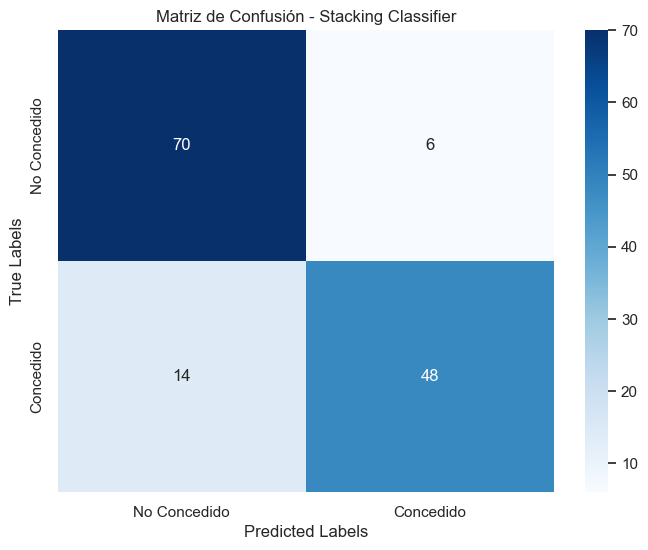

Reporte de Clasificación:
              precision    recall  f1-score   support

          NO       0.83      0.92      0.88        76
          SI       0.89      0.77      0.83        62

    accuracy                           0.86       138
   macro avg       0.86      0.85      0.85       138
weighted avg       0.86      0.86      0.85       138

Rendimiento en conjunto de entrenamiento (cv): 0.8676658476658476
Rendimiento en conjunto de test: 0.855072463768116


In [ ]:
# Dividir el dataset en características (X) y objetivo (y)
X = tarjeta_credito.drop(columns='concedido')
y = tarjeta_credito['concedido']

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=semilla)

# Identificar columnas categóricas y numéricas
cat_features = X.select_dtypes(include=['object']).columns  # Variables categóricas
num_features = X.select_dtypes(include=['int64', 'float64']).columns  # Variables numéricas

# Paso de preprocesamiento para variables categóricas y numéricas
preprocessor = ColumnTransformer([
    # Imputación y codificación para variables categóricas
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con la moda
        ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-Hot Encoding
    ]), cat_features),
    
    # Imputación para variables numéricas con KNNImputer
    ('num', Pipeline([
        ('imputer', KNNImputer(n_neighbors=5, weights='uniform')),  # Imputar con KNN
        ('passthrough', 'passthrough')  # Pasar las numéricas sin más cambios
    ]), num_features)
])

# Crear pipelines para clasificadores base
rf_pipeline = Pipeline([('preprocessor', preprocessor), 
                        ('randomforest', RandomForestClassifier(n_estimators=100, random_state=semilla))])

# Configurar AdaBoost con algoritmo SAMME
ada_pipeline = Pipeline([('preprocessor', preprocessor), 
                         ('adaboost', AdaBoostClassifier(n_estimators=100, algorithm='SAMME', random_state=semilla))])

gb_pipeline = Pipeline([('preprocessor', preprocessor), 
                        ('gradientboost', GradientBoostingClassifier(n_estimators=100, random_state=semilla))])

# Clasificador meta
meta_model = LogisticRegression(random_state=semilla)

# Crear el StackingClassifier
stacking_model = StackingClassifier(
    estimators=[
        ('random_forest', rf_pipeline),
        ('adaboost', ada_pipeline),
        ('gradient_boosting', gb_pipeline),
    ],
    final_estimator=meta_model,
    cv=5
)

# Realizar la validación cruzada en el conjunto de entrenamiento
cv_scores = cross_val_score(stacking_model, X_train, y_train, cv=5, scoring='accuracy')

# Promedio de las puntuaciones de validación cruzada
print("Puntuaciones de Validación Cruzada (5-fold):", cv_scores)
print("Promedio de Validación Cruzada:", cv_scores.mean())

# Ajustar el modelo Stacking
stacking_model.fit(X_train, y_train)

# Guardar el modelo
joblib.dump(stacking_model, ruta_modelos_stacking + 'modelo_stacking_knn_imputer.pkl')

# Realizar predicciones y evaluar
y_pred = stacking_model.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Concedido', 'Concedido'], yticklabels=['No Concedido', 'Concedido'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Matriz de Confusión - Stacking Classifier')
plt.show()

# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Comparar rendimiento en el conjunto de prueba con el de validación cruzada
train_accuracy = cv_scores.mean()
test_accuracy = classification_report(y_test, y_pred, output_dict=True)['accuracy']

print(f"Rendimiento en conjunto de entrenamiento (cv): {train_accuracy}")
print(f"Rendimiento en conjunto de test: {test_accuracy}")


# Evaluación de los modelos

| Modelo                       | Precision `SI` | Precision `NO` | Recall `SI` | Recall `NO` | F1-Score `SI` | F1-Score `NO` | Accuracy Test | CV Promedio | Observaciones                              |
|------------------------------|----------------|----------------|-------------|-------------|---------------|---------------|---------------|-------------|--------------------------------------------|
| ADA-SIN-NA                   | 0.83           | 0.91           | 0.90        | 0.85        | 0.86          | 0.88          | 0.87          | 0.8677      | Buen recall `SI`, menor recall `NO`.       |
| ADA-IMPUTACION-MEDIA-MODA    | 0.84           | 0.86           | 0.82        | 0.87        | 0.83          | 0.86          | 0.85          | 0.8605      | Mejor recall `NO`, menor recall `SI`.      |
| ADA-IMPUTACION-KNN           | 0.83           | 0.85           | 0.81        | 0.87        | 0.82          | 0.86          | 0.84          | 0.8641      | Similar a MEDIA; buen recall `NO`.         |
| Random-Forest-SIN-NA         | 0.91           | 0.87           | 0.83        | 0.93        | 0.87          | 0.90          | 0.89          | 0.8812      | Excelente recall `NO`, recall `SI` decente.|
| Random-Forest-IMPUTACION-MEDIA-MODA | 0.91   | 0.86           | 0.81        | 0.93        | 0.85          | 0.89          | 0.88          | 0.8858      | Muy buen recall `NO`, menor recall `SI`.   |
| Random-Forest-IMPUTACION-KNN | 0.91           | 0.84           | 0.77        | 0.93        | 0.83          | 0.88          | 0.86          | 0.8876      | Mejor para `NO`, menos efectivo en `SI`.   |
| STACKING-SIN-NA              | 0.89           | 0.87           | 0.83        | 0.92        | 0.86          | 0.89          | 0.88          | 0.8659      | Buen balance entre clases.                 |
| STACKING-IMPUTACION-MEDIA-MODA | 0.89        | 0.84           | 0.79        | 0.92        | 0.84          | 0.88          | 0.86          | 0.8677      | Buen recall `NO`, menor en `SI`.           |
| STACKING-IMPUTACION-KNN      | 0.89           | 0.83           | 0.77        | 0.92        | 0.83          | 0.88          | 0.86          | 0.8677      | Similar a STACKING-MEDIA.                  |



## Priorizar la precisión de `SI` (evitar pérdidas al banco por impagos):

**Mejor Modelo: `Random Forest - SIN NA`**

**Razón:**  
El modelo tiene una **precisión de 0.91 en `SI`**, lo que indica que un alto porcentaje de las personas a las que se les concede crédito son solventes. Esto reduce la posibilidad de que el banco otorgue créditos a personas que no van a poder pagarlos.  
El **recall en `SI` es 0.83**, lo cual es razonablemente alto, asegurando que no se pierdan demasiados buenos clientes.

## Priorizar el recall de `SI` (evitar rechazar a demasiados buenos clientes):

**Mejor Modelo: `ADA-SIN-NA`**

**Razón:**  
Este modelo tiene un **recall de 0.90 en `SI`**, lo que significa que es capaz de encontrar la mayoría de los clientes solventes, reduciendo el riesgo de rechazar clientes válidos.  
La **precisión en `SI` es 0.83**, lo que sigue siendo razonable para evitar demasiados falsos positivos, es decir, rechazar a clientes que podrían ser buenos.
